In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorly as tl
from tensorly.decomposition import tucker
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
data = pd.read_csv('ratings.txt')
data=data.dropna()
data['rating']=data['rating']/5
data = data.sort_values(by=['userid', 'itemid'])

In [3]:
dataplot = data.copy()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataplot.iloc[:,4] = le.fit_transform(dataplot.iloc[:,4])
dataplot.iloc[:,5] = le.fit_transform(dataplot.iloc[:,5])
dataplot.iloc[:,3] = le.fit_transform(dataplot.iloc[:,3])
data2=dataplot.copy()
dataplot.iloc[:,1] = le.fit_transform(dataplot.iloc[:,1])

In [4]:
user_id = data2['userid'].unique()
item_id = data2['itemid'].unique()
location = data2['Location'].unique()
companion = data2['Companion'].unique()
time = data2['Time'].unique()

In [5]:
def mapping(ids):
    count = 0
    keys_u = ids
    map_array = {}
    for i in keys_u:
        map_array[i] = count
        count = count + 1
    return map_array

In [6]:
map_users = mapping(user_id)
map_items = mapping(item_id)
map_loc = mapping(location)
map_tim = mapping(time)
map_com = mapping(companion)

In [7]:
tensor_loc = np.zeros([len(user_id),len(item_id),len(location)])
# 3D TENSOR for location
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_loc[data2.iloc[i,4]]
    rat = data2.iloc[i,2]
    tensor_loc[idx1,idx2,idx3] = rat

In [8]:
tensor_tim = np.zeros([len(user_id),len(item_id),len(time)])
# 3D TENSOR for time
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_tim[data2.iloc[i,3]]
    rat = data2.iloc[i,2]
    tensor_tim[idx1,idx2,idx3] = rat

In [9]:
tensor_com = np.zeros([len(user_id),len(item_id),len(companion)])
# 3D TENSOR for companion
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_com[data2.iloc[i,5]]
    rat = data2.iloc[i,2]
    tensor_com[idx1,idx2,idx3] = rat

# Hybrid

In [122]:
current_context1 = 0
current_context2 = 1
current_context3 = 1

In [123]:
index_context1 = map_loc[current_context1]
index_context2 = map_tim[current_context2]
index_context3 = map_com[current_context3]

In [124]:
matrix_context1=tensor_loc[:,:,index_context1]
matrix_context2=tensor_tim[:,:,index_context2]
matrix_context3=tensor_com[:,:,index_context3]

In [125]:
matrix_context1=np.array(matrix_context1)
matrix_context2=np.array(matrix_context2)
matrix_context3=np.array(matrix_context3)

In [126]:
tensor3d=np.dstack((matrix_context1,matrix_context2,matrix_context3))

In [127]:
tensor3d.shape

(81, 79, 3)

In [128]:
factors3d = tucker(tensor3d , ranks=[35,35,2])

In [129]:
U1 = factors3d[1][0]
I1 = factors3d[1][1]
C1 = factors3d[1][2]

In [130]:
wcss = []
for i in range(1,81):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(U1)
    wcss.append(kmeans.inertia_)

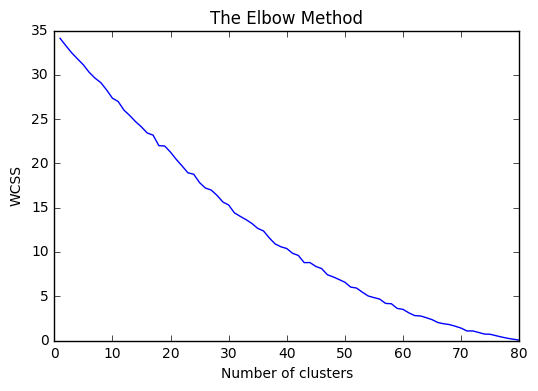

In [131]:
plt.plot(range(1, 81), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [132]:
kmeans = KMeans(n_clusters=34, random_state=0)
y1 = kmeans.fit_predict(U1)
kmeans = KMeans(n_clusters=35, random_state=0)
y2 = kmeans.fit_predict(U1)
kmeans = KMeans(n_clusters=33, random_state=0)
y3 = kmeans.fit_predict(U1)
kmeans = KMeans(n_clusters=25, random_state=0)
y4 = kmeans.fit_predict(U1)

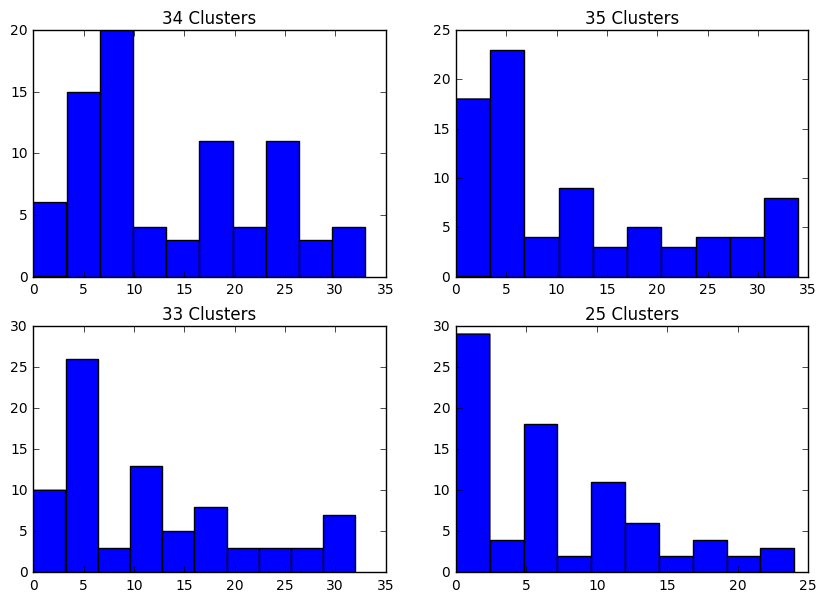

In [133]:
fig, ax = plt.subplots(2,2, figsize=(10, 7))
ax[0,0].hist(y1)
ax[0,0].set_title("34 Clusters")
ax[0,1].hist(y2)
ax[0,1].set_title("35 Clusters")
ax[1,0].hist(y3)
ax[1,0].set_title("33 Clusters")
ax[1,1].hist(y4)
ax[1,1].set_title("25 Clusters")

In [134]:
tensor5d = np.zeros([len(user_id),len(item_id),len(location),len(time),len(companion)])

In [135]:
for i in range(data2.shape[0]):
    idx1 = map_users[data2.iloc[i,0]]
    idx2 = map_items[data2.iloc[i,1]]
    idx3 = map_loc[data2.iloc[i,4]]
    idx4 = map_tim[data2.iloc[i,3]]
    idx5 = map_com[data2.iloc[i,5]]
    rat = data2.iloc[i,2]
    tensor5d[idx1,idx2,idx3,idx4,idx5] = rat

In [136]:
matrix_context = tensor5d[:,:,index_context1,index_context2,index_context3]

In [137]:
current_user = 1001
index_user = map_users[current_user]
cluster_user = y1[index_user]

In [138]:
cluster_user

7

In [139]:
sim_user_id = []
for i in range(len(y1)):
    if(y1[i]==cluster_user and user_id[i]!=current_user):
        sim_user_id.append(user_id[i])

In [140]:
cluster=[]
for i in range(len(user_id)):
    if y1[i]==cluster_user and i!=index_user :
        cluster.append(i)

In [141]:
len(cluster)

16

In [142]:
similar_users = []
for i in cluster:
    similar_users.append(matrix_context[i])
su = similar_users.copy()
su.append(matrix_context[map_users[current_user]])


In [143]:
su_mean=[]
count=0
mean=0
for i in range(len(su)):
    for j in range(len(item_id)):
        if su[i][j]:
            count = count + 1
            mean = mean + su[i][j]
    if count:
        su_mean.append(mean/count)
    else:
        su_mean.append(0)
    mean=0
    count=0

In [144]:
import math
corr_matrix=[]
corr_m = []
sumxy=0
sumyy2=0
sumxx2=0
corr=0
for i in range(len(su)):
    for j in range(len(su)):
        for k in range(len(item_id)):
            if su[i][k] and su[j][k]:
                sumxy= sumxy + (su[i][k]-su_mean[i])*(su[j][k]-su_mean[j])
                sumxx2= sumxx2 + (su[i][k]-su_mean[i])*(su[i][k]-su_mean[i])
                sumyy2= sumyy2 + (su[j][k]-su_mean[j])*(su[j][k]-su_mean[j])
        if sumxx2 and sumyy2 :
            corr=sumxy/math.sqrt(sumxx2*sumyy2)
        else:
            corr=0
            
        corr_m.append(corr)
        sumxy=0
        sumyy2=0
        sumxx2=0
    corr_matrix.append(corr_m)
    corr_m = []
        
        

In [145]:
corr_matrix = np.array(corr_matrix)
corr_matrix

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.87038828,  1.        ,
         0.        ,  0.        , -1.        ,  0.        ,  0.        ,
         0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        

In [146]:
similar_users = np.array(similar_users)

In [147]:
similar_users.shape

(16, 79)

In [148]:
relevant_items=[]
count = 0
for i in range(len(item_id)):
    for j in range(len(cluster)):
        if(similar_users[j][i]>0.5):
            count = count + 1
    relevant_items.append(count)
    count = 0

In [149]:
itemx=[]
for i in range(len(relevant_items)):
    temp=[]
    temp.append(item_id[i])
    temp.append(relevant_items[i])
    itemx.append(temp)

In [150]:
itemx = np.array(itemx)
itemx

array([['tt0088763', '1'],
       ['tt0111161', '1'],
       ['tt0120338', '1'],
       ['tt0133093', '3'],
       ['tt0211915', '2'],
       ['tt0266543', '2'],
       ['tt0362165', '0'],
       ['tt0378194', '1'],
       ['tt0405422', '1'],
       ['tt0462538', '0'],
       ['tt1232829', '1'],
       ['tt1453405', '0'],
       ['tt1707386', '1'],
       ['tt0109830', '2'],
       ['tt0114369', '1'],
       ['tt0367594', '0'],
       ['tt0382625', '1'],
       ['tt0993846', '0'],
       ['tt2557490', '0'],
       ['tt3793764', '1'],
       ['tt0110357', '1'],
       ['tt0114148', '0'],
       ['tt0120912', '1'],
       ['tt0454876', '1'],
       ['tt1099212', '0'],
       ['tt1291150', '0'],
       ['tt0110475', '0'],
       ['tt0125439', '0'],
       ['tt0138097', '0'],
       ['tt0181689', '1'],
       ['tt0289879', '0'],
       ['tt0293662', '0'],
       ['tt0319262', '1'],
       ['tt0327084', '0'],
       ['tt0489099', '0'],
       ['tt0800369', '1'],
       ['tt0945513', '0'],
 

In [151]:
# sorting in reverse(top 10 iStems)
itemx = itemx[itemx[:,1].argsort()[::-1]]

In [152]:
itemx[0:10, :]

array([['tt0133093', '3'],
       ['tt0109830', '2'],
       ['tt1657301', '2'],
       ['tt0211915', '2'],
       ['tt0266543', '2'],
       ['tt0110357', '1'],
       ['tt1596343', '1'],
       ['tt0382625', '1'],
       ['tt0800369', '1'],
       ['tt3793764', '1']], 
      dtype='<U9')

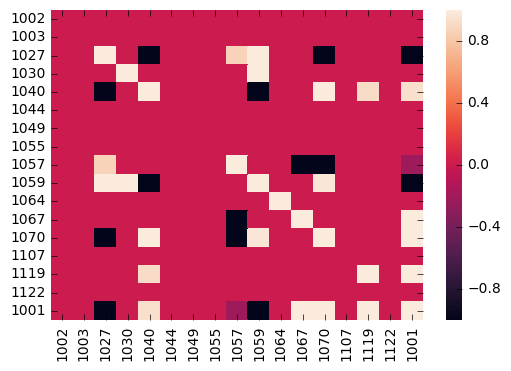

In [153]:
sim_user_id.append(current_user)
import seaborn as sns
sns.heatmap(corr_matrix, xticklabels=sim_user_id, yticklabels=sim_user_id)